In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.tseries.offsets import BDay
import random

# ALL data

In [3]:
all_ = pd.read_csv("./dataset/SP500/ALL.csv")
all_["date"] = pd.to_datetime(all_["date"])
print(all_.shape)
all_

(37745224, 7)


,date,open,high,low,close,volume,ticker
0,2024-01-02 09:30:00,1592.79,1592.79,1592.79,1592.79,559.0,TPL
1,2024-01-02 10:55:00,1618.76,1618.76,1618.76,1618.76,139.0,TPL
2,2024-01-02 11:05:00,1617.02,1617.02,1617.02,1617.02,753.0,TPL
3,2024-01-02 11:08:00,1619.00,1619.00,1619.00,1619.00,467.0,TPL
4,2024-01-02 11:19:00,1623.97,1623.97,1623.97,1623.97,632.0,TPL
...,...,...,...,...,...,...,...
37745219,2024-11-07 15:55:00,121.09,121.15,121.06,121.11,50127.0,XOM
37745220,2024-11-07 15:56:00,121.11,121.15,121.09,121.15,50994.0,XOM
37745221,2024-11-07 15:57:00,121.15,121.15,121.07,121.09,52459.0,XOM
37745222,2024-11-07 15:58:00,121.10,121.13,121.04,121.05,95864.0,XOM


# Normalization

In [4]:
# Initialize the scaler
scaler = MinMaxScaler(feature_range=(1e-6, 1.0))  # Set minimum to 1e-6

In [5]:
# Get numeric columns
numeric_columns = all_.select_dtypes(include=[np.number]).columns
print(numeric_columns)

Index(['open', 'high', 'low', 'close', 'volume'], dtype='object')


In [6]:
# Initialize an empty DataFrame to store the normalized data
normalized_df = pd.DataFrame()

In [7]:
# Group by 'Company' and apply the scaler to each group
for company, group in all_.groupby('ticker'):
    # Initialize the scaler with minimum 1e-6
    scaler = MinMaxScaler(feature_range=(1e-3, 1.0))
    
    # Fit and transform the numeric columns for each company
    group_scaled = group.copy()
    group_scaled[numeric_columns] = scaler.fit_transform(group[numeric_columns])
    
    # Append the normalized group to the normalized_df
    normalized_df = pd.concat([normalized_df, group_scaled])

# Sort the normalized DataFrame by date to maintain order
normalized_df = normalized_df.sort_index()

In [8]:
print(normalized_df.shape)
normalized_df.date = pd.to_datetime(normalized_df.date)
normalized_df = normalized_df.set_index("date")
normalized_df

(37745224, 7)


,open,high,low,close,volume,ticker
date,,,,,,
2024-01-02 09:30:00,0.970750,0.970750,0.970750,0.970750,0.016565,TPL
2024-01-02 10:55:00,0.993658,0.993658,0.993658,0.993658,0.004870,TPL
2024-01-02 11:05:00,0.992123,0.992123,0.992123,0.992123,0.021966,TPL
2024-01-02 11:08:00,0.993870,0.993870,0.993870,0.993870,0.014003,TPL
2024-01-02 11:19:00,0.998253,0.998253,0.998253,0.998253,0.018597,TPL
...,...,...,...,...,...,...
2024-11-07 15:55:00,0.829971,0.829755,0.830984,0.830355,0.011650,XOM
2024-11-07 15:56:00,0.830628,0.829755,0.831968,0.831668,0.011839,XOM
2024-11-07 15:57:00,0.831941,0.829755,0.831312,0.829699,0.012157,XOM


# Make data uniform

Some data have different time frequencies, so we need to make this data uniform and later we need to filter only for training days

In [9]:
valid_trading_days = pd.date_range(
    start=normalized_df.index.min().date(),
    end=normalized_df.index.max().date(),
    freq=BDay()  # Business days only
)
valid_trading_days = valid_trading_days.date

In [10]:
normalized_df.shape

(37745224, 6)

In [11]:
# Define stock market opening and closing times
market_open = pd.to_datetime("09:30").time()
market_close = pd.to_datetime("15:59").time()

# Resample data for each ticker to 1-minute intervals and forward-fill missing rows
uniform_data = (
    normalized_df.groupby("ticker")  # Group by ticker
    .apply(lambda group: group.resample("1T").ffill())  # Resample to 1 minute and forward-fill
    .reset_index(level=0, drop=True)  # Remove the grouped ticker level from the index
    .reset_index()  # Reset the index to flatten the dataframe
)

# Filter out rows outside market hours
uniform_data = uniform_data[
    (uniform_data['date'].dt.time >= market_open) &
    (uniform_data['date'].dt.time <= market_close)
]

print(uniform_data.shape)

uniform_data

(60280711, 7)


,date,open,high,low,close,volume,ticker
0,2024-01-02 09:30:00,0.450791,0.447896,0.450573,0.447855,0.018427,A
1,2024-01-02 09:31:00,0.448217,0.445322,0.446930,0.444214,0.002054,A
2,2024-01-02 09:32:00,0.447252,0.444357,0.448861,0.446144,0.001605,A
3,2024-01-02 09:33:00,0.447413,0.473957,0.449022,0.469301,0.006264,A
4,2024-01-02 09:34:00,0.470739,0.482643,0.471704,0.484418,0.003045,A
...,...,...,...,...,...,...,...
222053156,2024-11-07 15:55:00,0.515130,0.515049,0.518042,0.518004,0.046645,ZTS
222053157,2024-11-07 15:56:00,0.515310,0.516845,0.518946,0.520170,0.067035,ZTS
222053158,2024-11-07 15:57:00,0.517464,0.521694,0.522202,0.525583,0.079007,ZTS
222053159,2024-11-07 15:58:00,0.522491,0.525107,0.527265,0.528290,0.108587,ZTS


In [12]:
uniform_data["date_day"] = pd.to_datetime(uniform_data["date"]).dt.date
uniform_data["date_day"] = pd.to_datetime(uniform_data["date_day"])
uniform_data_ = uniform_data[uniform_data["date_day"].dt.date.isin(
    valid_trading_days)]
print(uniform_data_.shape)
uniform_data_

(43223671, 8)


,date,open,high,low,close,volume,ticker,date_day
0,2024-01-02 09:30:00,0.450791,0.447896,0.450573,0.447855,0.018427,A,2024-01-02
1,2024-01-02 09:31:00,0.448217,0.445322,0.446930,0.444214,0.002054,A,2024-01-02
2,2024-01-02 09:32:00,0.447252,0.444357,0.448861,0.446144,0.001605,A,2024-01-02
3,2024-01-02 09:33:00,0.447413,0.473957,0.449022,0.469301,0.006264,A,2024-01-02
4,2024-01-02 09:34:00,0.470739,0.482643,0.471704,0.484418,0.003045,A,2024-01-02
...,...,...,...,...,...,...,...,...
222053156,2024-11-07 15:55:00,0.515130,0.515049,0.518042,0.518004,0.046645,ZTS,2024-11-07
222053157,2024-11-07 15:56:00,0.515310,0.516845,0.518946,0.520170,0.067035,ZTS,2024-11-07
222053158,2024-11-07 15:57:00,0.517464,0.521694,0.522202,0.525583,0.079007,ZTS,2024-11-07
222053159,2024-11-07 15:58:00,0.522491,0.525107,0.527265,0.528290,0.108587,ZTS,2024-11-07


Let's skip the first day to make the data symmetric.

In [13]:
# Define the start and end dates as datetime objects
start_date = pd.to_datetime('2024-01-03 00:00')
end_date = pd.to_datetime('2024-11-07 00:00')

# Filter rows within the date range
uniform_data_ = uniform_data_[
    (uniform_data_['date'] >= start_date) & (uniform_data_['date'] <= end_date)
]
uniform_data_

,date,open,high,low,close,volume,ticker,date_day
1440,2024-01-03 09:30:00,0.444678,0.441783,0.419583,0.417840,0.014947,A,2024-01-03
1441,2024-01-03 09:31:00,0.417330,0.414435,0.406713,0.404009,0.006376,A,2024-01-03
1442,2024-01-03 09:32:00,0.400278,0.397383,0.366174,0.364770,0.019458,A,2024-01-03
1443,2024-01-03 09:33:00,0.365852,0.369391,0.330139,0.328747,0.030145,A,2024-01-03
1444,2024-01-03 09:34:00,0.326278,0.323704,0.310030,0.312015,0.018307,A,2024-01-03
...,...,...,...,...,...,...,...,...
222051716,2024-11-06 15:55:00,0.453736,0.455417,0.457097,0.458273,0.042138,ZTS,2024-11-06
222051717,2024-11-06 15:56:00,0.455532,0.458830,0.459267,0.461702,0.062207,ZTS,2024-11-06
222051718,2024-11-06 15:57:00,0.458942,0.462063,0.462522,0.464770,0.050622,ZTS,2024-11-06
222051719,2024-11-06 15:58:00,0.462174,0.463141,0.464331,0.463687,0.114378,ZTS,2024-11-06


Let's check if all stocks have the same number of data points

In [14]:
group_sizes = uniform_data_.groupby("ticker").size()

if group_sizes.nunique() == 1:
    print("All groups have the same size.")
else:
    print("Groups have different sizes.")
print("Group Sizes:\n", group_sizes)

All groups have the same size.
Group Sizes:
 ticker
A       86190
AAPL    86190
ABBV    86190
ABNB    86190
ABT     86190
        ...  
XYL     86190
YUM     86190
ZBH     86190
ZBRA    86190
ZTS     86190
Length: 497, dtype: int64


# Calculating daily variation

In [15]:
uniform_data_daily = uniform_data_.groupby(['ticker', 'date_day']).agg({
    'close': 'last',
    # Include other aggregations if necessary
}).reset_index()
uniform_data_daily

,ticker,date_day,close
0,A,2024-01-03,0.223572
1,A,2024-01-04,0.218426
2,A,2024-01-05,0.204274
3,A,2024-01-08,0.294975
4,A,2024-01-09,0.207812
...,...,...,...
109832,ZTS,2024-10-31,0.612924
109833,ZTS,2024-11-01,0.670850
109834,ZTS,2024-11-04,0.550486
109835,ZTS,2024-11-05,0.550125


In [16]:
uniform_data_daily = uniform_data_daily.sort_values(by=[
    'ticker', 'date_day'])
uniform_data_daily['variation'] = uniform_data_daily.groupby(
    'ticker')['close'].pct_change() * 100
uniform_data_daily['variation'] = uniform_data_daily['variation'].fillna(
    0)  # Replace NaN with 0 if desired
uniform_data_daily

,ticker,date_day,close,variation
0,A,2024-01-03,0.223572,0.000000
1,A,2024-01-04,0.218426,-2.301797
2,A,2024-01-05,0.204274,-6.479077
3,A,2024-01-08,0.294975,44.401819
4,A,2024-01-09,0.207812,-29.549374
...,...,...,...,...
109832,ZTS,2024-10-31,0.612924,-10.653573
109833,ZTS,2024-11-01,0.670850,9.450790
109834,ZTS,2024-11-04,0.550486,-17.941965
109835,ZTS,2024-11-05,0.550125,-0.065562


In [17]:
uniform_data_ = pd.merge(uniform_data_, 
    uniform_data_daily[['ticker', 'date_day', 'variation']], 
    on=['ticker', 'date_day'], 
    how='left'
)
uniform_data_

,date,open,high,low,close,volume,ticker,date_day,variation
0,2024-01-03 09:30:00,0.444678,0.441783,0.419583,0.417840,0.014947,A,2024-01-03,0.000000
1,2024-01-03 09:31:00,0.417330,0.414435,0.406713,0.404009,0.006376,A,2024-01-03,0.000000
2,2024-01-03 09:32:00,0.400278,0.397383,0.366174,0.364770,0.019458,A,2024-01-03,0.000000
3,2024-01-03 09:33:00,0.365852,0.369391,0.330139,0.328747,0.030145,A,2024-01-03,0.000000
4,2024-01-03 09:34:00,0.326278,0.323704,0.310030,0.312015,0.018307,A,2024-01-03,0.000000
...,...,...,...,...,...,...,...,...,...
42836425,2024-11-06 15:55:00,0.453736,0.455417,0.457097,0.458273,0.042138,ZTS,2024-11-06,-15.942049
42836426,2024-11-06 15:56:00,0.455532,0.458830,0.459267,0.461702,0.062207,ZTS,2024-11-06,-15.942049
42836427,2024-11-06 15:57:00,0.458942,0.462063,0.462522,0.464770,0.050622,ZTS,2024-11-06,-15.942049
42836428,2024-11-06 15:58:00,0.462174,0.463141,0.464331,0.463687,0.114378,ZTS,2024-11-06,-15.942049


# Ticker Visualization

In [18]:
# Select a ticker (e.g., 'AAPL')
ticker = 'A'

# Get normalized data for the ticker
resampled_data_ticker = uniform_data_.loc[
    uniform_data_['ticker'] == ticker
]
resampled_data_ticker.set_index("date", inplace=True)
resampled_data_ticker.index = pd.to_datetime(
    resampled_data_ticker.index
)

resampled_data_ticker

,open,high,low,close,volume,ticker,date_day,variation
date,,,,,,,,
2024-01-03 09:30:00,0.444678,0.441783,0.419583,0.417840,0.014947,A,2024-01-03,0.000000
2024-01-03 09:31:00,0.417330,0.414435,0.406713,0.404009,0.006376,A,2024-01-03,0.000000
2024-01-03 09:32:00,0.400278,0.397383,0.366174,0.364770,0.019458,A,2024-01-03,0.000000
2024-01-03 09:33:00,0.365852,0.369391,0.330139,0.328747,0.030145,A,2024-01-03,0.000000
2024-01-03 09:34:00,0.326278,0.323704,0.310030,0.312015,0.018307,A,2024-01-03,0.000000
...,...,...,...,...,...,...,...,...
2024-11-06 15:55:00,0.429878,0.430522,0.429878,0.431670,0.017676,A,2024-11-06,-16.624499
2024-11-06 15:56:00,0.432130,0.436957,0.433739,0.438103,0.022205,A,2024-11-06,-16.624499
2024-11-06 15:57:00,0.439530,0.439209,0.438887,0.436173,0.035451,A,2024-11-06,-16.624499


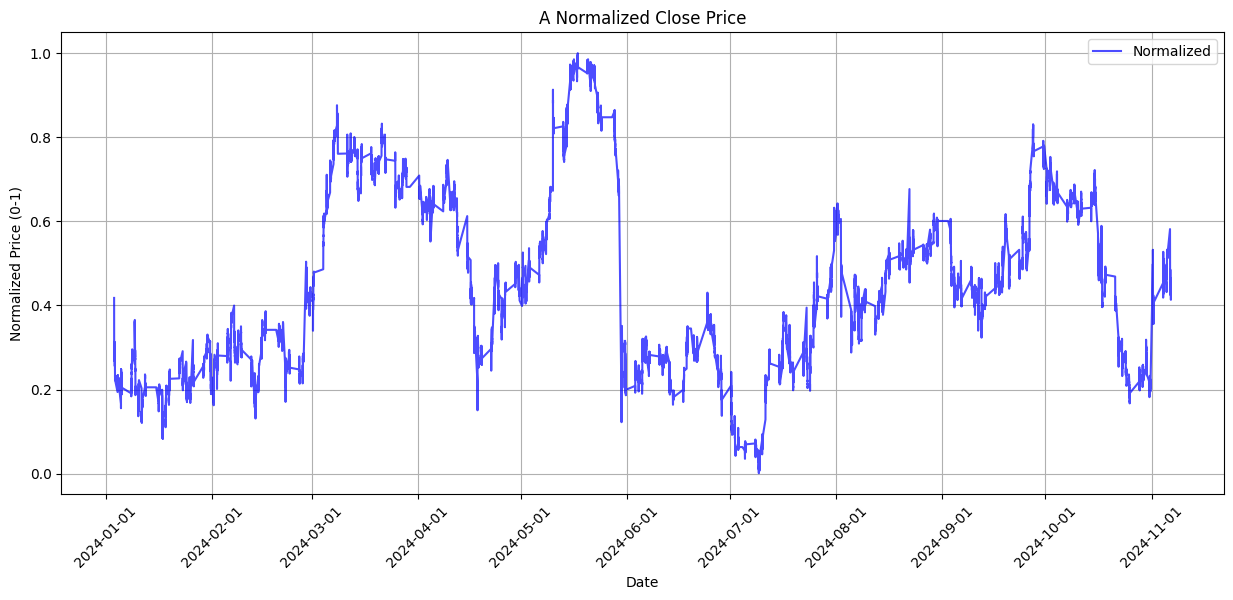

In [19]:
# Create the plot
plt.figure(figsize=(15, 6))

# Plot normalized data
plt.plot(
    resampled_data_ticker.index,
    resampled_data_ticker['close'],
    label='Normalized', color='blue', alpha=0.7
)

# Format the x-axis to show dates properly
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add title and labels
plt.title(f'{ticker} Normalized Close Price')
plt.xlabel('Date')
plt.ylabel('Normalized Price (0-1)')
plt.legend()
plt.grid(True)

# Filter Data

We'll filter our dataset to make it shorter for our StockMixer preprocessing. The goal is to use the following data splits:

```
Training: from 2024-10-30 09:30:00 to 2024-11-04 15:59:00    
Length: 1559
```

```
Validation: from 2024-11-05 09:30:00 to 2024-11-05 15:59:00    
Length: 389
```

```
Testing: from 2024-11-05 15:58:00 to 2024-11-06 15:59:00.     
Length: 391
```

In [20]:
# Define the start and end dates as datetime objects
start_date = pd.to_datetime('2024-10-30 00:00')
end_date = pd.to_datetime('2024-11-07 00:00')

print("Before: ", len(uniform_data_.date.unique()))
# Filter rows within the date range
uniform_data_reduced = uniform_data_[
    (uniform_data_['date'] >= start_date) & (uniform_data_['date'] <= end_date)
]
print("After: ", len(uniform_data_reduced.date.unique()))
uniform_data_reduced

Before:  86190
After:  2340


,date,open,high,low,close,volume,ticker,date_day,variation
83850,2024-10-30 09:30:00,0.240696,0.248417,0.225574,0.250268,0.020909,A,2024-10-30,3.829195
83851,2024-10-30 09:31:00,0.245200,0.264504,0.246809,0.266028,0.007467,A,2024-10-30,3.829195
83852,2024-10-30 09:32:00,0.266757,0.264504,0.268365,0.266349,0.002215,A,2024-10-30,3.829195
83853,2024-10-30 09:33:00,0.254852,0.280591,0.256461,0.282431,0.002396,A,2024-10-30,3.829195
83854,2024-10-30 09:34:00,0.276730,0.280591,0.268687,0.282431,0.011620,A,2024-10-30,3.829195
...,...,...,...,...,...,...,...,...,...
42836425,2024-11-06 15:55:00,0.453736,0.455417,0.457097,0.458273,0.042138,ZTS,2024-11-06,-15.942049
42836426,2024-11-06 15:56:00,0.455532,0.458830,0.459267,0.461702,0.062207,ZTS,2024-11-06,-15.942049
42836427,2024-11-06 15:57:00,0.458942,0.462063,0.462522,0.464770,0.050622,ZTS,2024-11-06,-15.942049
42836428,2024-11-06 15:58:00,0.462174,0.463141,0.464331,0.463687,0.114378,ZTS,2024-11-06,-15.942049


# Exponential Moving average

In [21]:
# EMA (Exponential Moving Average) is a type of moving average that gives more weight to recent price data. 
# For one-minute bars, a common lookback period is 45 minutes, which is equivalent to 9 * 5 minutes.
ema_one_minute_bars = 9 * 5

# SMA (Simple Moving Average) is a type of moving average that gives equal weight to all price data in the lookback period.
# For daily bars, a common lookback period is 50 days.
sma_daily_bars = 50

In [22]:
uniform_data_reduced["EMA"] = uniform_data_reduced.groupby(["ticker", "date"])["close"].transform(
    lambda x: x.ewm(span=ema_one_minute_bars).mean()
)
uniform_data_reduced

/tmp/ipykernel_684251/335466707.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uniform_data_reduced["EMA"] = uniform_data_reduced.groupby(["ticker", "date"])["close"].transform(


,date,open,high,low,close,volume,ticker,date_day,variation,EMA
83850,2024-10-30 09:30:00,0.240696,0.248417,0.225574,0.250268,0.020909,A,2024-10-30,3.829195,0.250268
83851,2024-10-30 09:31:00,0.245200,0.264504,0.246809,0.266028,0.007467,A,2024-10-30,3.829195,0.266028
83852,2024-10-30 09:32:00,0.266757,0.264504,0.268365,0.266349,0.002215,A,2024-10-30,3.829195,0.266349
83853,2024-10-30 09:33:00,0.254852,0.280591,0.256461,0.282431,0.002396,A,2024-10-30,3.829195,0.282431
83854,2024-10-30 09:34:00,0.276730,0.280591,0.268687,0.282431,0.011620,A,2024-10-30,3.829195,0.282431
...,...,...,...,...,...,...,...,...,...,...
42836425,2024-11-06 15:55:00,0.453736,0.455417,0.457097,0.458273,0.042138,ZTS,2024-11-06,-15.942049,0.458273
42836426,2024-11-06 15:56:00,0.455532,0.458830,0.459267,0.461702,0.062207,ZTS,2024-11-06,-15.942049,0.461702
42836427,2024-11-06 15:57:00,0.458942,0.462063,0.462522,0.464770,0.050622,ZTS,2024-11-06,-15.942049,0.464770
42836428,2024-11-06 15:58:00,0.462174,0.463141,0.464331,0.463687,0.114378,ZTS,2024-11-06,-15.942049,0.463687


# Sectors maping

Now we want to use the SP500 to make our sectors into our dataset

In [24]:
sp500 = pd.read_csv("./dataset/SP500/sp500.csv")
print(sp500.shape)
sp500

(503, 8)


,symbol,name,sector,subSector,headQuarter,dateFirstAdded,cik,founded
0,TPL,Texas Pacific Land Corporation,Energy,Oil & Gas Exploration & Production,"Dallas, Texas",2024-11-26,1811074,1888
1,AMTM,Amentum,Industrials,Diversified Support Services,"Chantilly, Virginia",2024-09-30,2011286,2020
2,DELL,Dell Technologies,Information Technology,"Technology Hardware, Storage & Peripherals","Round Rock, Texas",2024-09-23,1571996,2016
3,ERIE,Erie Indemnity,Financials,Insurance Brokers,"Erie, Pennsylvania",2024-09-23,922621,1925
4,PLTR,Palantir Technologies,Information Technology,Internet Services & Infrastructure,"Denver, Colorado",2024-09-23,1321655,2003
...,...,...,...,...,...,...,...,...
498,SO,Southern Company,Utilities,Electric Utilities,"Atlanta, Georgia",1957-03-04,92122,1945
499,SPGI,S&P Global,Financials,Financial Exchanges & Data,"New York City, New York",1957-03-04,64040,1917
500,UNP,Union Pacific Corporation,Industrials,Rail Transportation,"Omaha, Nebraska",1957-03-04,100885,1862
501,XEL,Xcel Energy,Utilities,Multi-Utilities,"Minneapolis, Minnesota",1957-03-04,72903,1909


In [25]:
# Sectors
print(sp500["sector"].unique())

['Energy' 'Industrials' 'Information Technology' 'Financials' 'Materials'
 'Utilities' 'Health Care' 'Consumer Discretionary' 'Consumer Staples'
 'Real Estate' 'Communication Services']


In [26]:
# Create a mapping dictionary from company_df
ticker_to_sector = dict(zip(sp500["symbol"], sp500["sector"]))

In [27]:
# Map the sector information to the stock_df
uniform_data_reduced["sector"] = uniform_data_reduced["ticker"].map(ticker_to_sector)
uniform_data_reduced

/tmp/ipykernel_684251/3678987359.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uniform_data_reduced["sector"] = uniform_data_reduced["ticker"].map(ticker_to_sector)


,date,open,high,low,close,volume,ticker,date_day,variation,EMA,sector
83850,2024-10-30 09:30:00,0.240696,0.248417,0.225574,0.250268,0.020909,A,2024-10-30,3.829195,0.250268,Health Care
83851,2024-10-30 09:31:00,0.245200,0.264504,0.246809,0.266028,0.007467,A,2024-10-30,3.829195,0.266028,Health Care
83852,2024-10-30 09:32:00,0.266757,0.264504,0.268365,0.266349,0.002215,A,2024-10-30,3.829195,0.266349,Health Care
83853,2024-10-30 09:33:00,0.254852,0.280591,0.256461,0.282431,0.002396,A,2024-10-30,3.829195,0.282431,Health Care
83854,2024-10-30 09:34:00,0.276730,0.280591,0.268687,0.282431,0.011620,A,2024-10-30,3.829195,0.282431,Health Care
...,...,...,...,...,...,...,...,...,...,...,...
42836425,2024-11-06 15:55:00,0.453736,0.455417,0.457097,0.458273,0.042138,ZTS,2024-11-06,-15.942049,0.458273,Health Care
42836426,2024-11-06 15:56:00,0.455532,0.458830,0.459267,0.461702,0.062207,ZTS,2024-11-06,-15.942049,0.461702,Health Care
42836427,2024-11-06 15:57:00,0.458942,0.462063,0.462522,0.464770,0.050622,ZTS,2024-11-06,-15.942049,0.464770,Health Care
42836428,2024-11-06 15:58:00,0.462174,0.463141,0.464331,0.463687,0.114378,ZTS,2024-11-06,-15.942049,0.463687,Health Care


Let's save a backup of the dataset, just in case

In [28]:
uniform_data_reduced_bkp = uniform_data_reduced.copy()

# Political sentiment

Our goal is to map which sectors of the economy will benefit from each candidate based on their political opinions as we have gathered in our final political statement report.

In [100]:
uniform_data_political = uniform_data_reduced.copy()

In [101]:
# Define the sector impact mapping for each candidate
candidate_sector_impact = {
    "candidate1": { # Donald Trump
        "Energy": 1,                    # Positive impact
        "Industrials": 1,               # Positive impact
        "Financials": 1,                # Positive impact
        "Materials": 1,                 # Positive impact
        "Consumer Discretionary": 1,    # Positive impact
        "Real Estate": 1,               # Positive impact
        "Utilities": 1,                 # Positive impact
        "Communication Services": 1,     # Positive impact
        "Information Technology": -1,   # Negative impact
        "Health Care": -1,              # Negative impact
        "Consumer Staples": -1,         # Negative impact
    },
    "candidate2": { # Kamala Harris
        "Energy": -1,                    # Negative impact
        "Industrials": -1,               # Negative impact
        "Financials": -1,                # Negative impact
        "Materials": -1,                 # Negative impact
        "Consumer Discretionary": -1,    # Negative impact
        "Real Estate": -1,               # Negative impact
        "Utilities": -1,                 # Negative impact
        "Communication Services": -1,    # Negative impact
        "Information Technology": 1,     # Positive impact
        "Health Care": 1,                # Positive impact
        "Consumer Staples": 1,           # Positive impact
    }
}

In [102]:
# Add candidate-specific impact columns
uniform_data_political["candidate1_impact"] = uniform_data_political["sector"].map(
    candidate_sector_impact["candidate1"]
)
uniform_data_political["candidate2_impact"] = uniform_data_political["sector"].map(
    candidate_sector_impact["candidate2"]
)
uniform_data_political


,date,open,high,low,close,volume,ticker,date_day,variation,EMA,sector,candidate1_impact,candidate2_impact
83850,2024-10-30 09:30:00,0.240696,0.248417,0.225574,0.250268,0.020909,A,2024-10-30,3.829195,0.250268,Health Care,-1,1
83851,2024-10-30 09:31:00,0.245200,0.264504,0.246809,0.266028,0.007467,A,2024-10-30,3.829195,0.266028,Health Care,-1,1
83852,2024-10-30 09:32:00,0.266757,0.264504,0.268365,0.266349,0.002215,A,2024-10-30,3.829195,0.266349,Health Care,-1,1
83853,2024-10-30 09:33:00,0.254852,0.280591,0.256461,0.282431,0.002396,A,2024-10-30,3.829195,0.282431,Health Care,-1,1
83854,2024-10-30 09:34:00,0.276730,0.280591,0.268687,0.282431,0.011620,A,2024-10-30,3.829195,0.282431,Health Care,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42836425,2024-11-06 15:55:00,0.453736,0.455417,0.457097,0.458273,0.042138,ZTS,2024-11-06,-15.942049,0.458273,Health Care,-1,1
42836426,2024-11-06 15:56:00,0.455532,0.458830,0.459267,0.461702,0.062207,ZTS,2024-11-06,-15.942049,0.461702,Health Care,-1,1
42836427,2024-11-06 15:57:00,0.458942,0.462063,0.462522,0.464770,0.050622,ZTS,2024-11-06,-15.942049,0.464770,Health Care,-1,1
42836428,2024-11-06 15:58:00,0.462174,0.463141,0.464331,0.463687,0.114378,ZTS,2024-11-06,-15.942049,0.463687,Health Care,-1,1


In order to simulate which candidate is going to win, let's randomly select them

In [103]:
# candidate_context = 1 (Donald Trump)
# candidate_context = 2 (Kamala Harris)

uniform_data_political["candidate_context"] = uniform_data_political.apply(
    lambda row: random.choice(
        [1, 2]) if row["date_day"] < pd.Timestamp("2024-11-06") else 1,
    axis=1
)
uniform_data_political

,date,open,high,low,close,volume,ticker,date_day,variation,EMA,sector,candidate1_impact,candidate2_impact,candidate_context
83850,2024-10-30 09:30:00,0.240696,0.248417,0.225574,0.250268,0.020909,A,2024-10-30,3.829195,0.250268,Health Care,-1,1,2
83851,2024-10-30 09:31:00,0.245200,0.264504,0.246809,0.266028,0.007467,A,2024-10-30,3.829195,0.266028,Health Care,-1,1,2
83852,2024-10-30 09:32:00,0.266757,0.264504,0.268365,0.266349,0.002215,A,2024-10-30,3.829195,0.266349,Health Care,-1,1,2
83853,2024-10-30 09:33:00,0.254852,0.280591,0.256461,0.282431,0.002396,A,2024-10-30,3.829195,0.282431,Health Care,-1,1,2
83854,2024-10-30 09:34:00,0.276730,0.280591,0.268687,0.282431,0.011620,A,2024-10-30,3.829195,0.282431,Health Care,-1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42836425,2024-11-06 15:55:00,0.453736,0.455417,0.457097,0.458273,0.042138,ZTS,2024-11-06,-15.942049,0.458273,Health Care,-1,1,1
42836426,2024-11-06 15:56:00,0.455532,0.458830,0.459267,0.461702,0.062207,ZTS,2024-11-06,-15.942049,0.461702,Health Care,-1,1,1
42836427,2024-11-06 15:57:00,0.458942,0.462063,0.462522,0.464770,0.050622,ZTS,2024-11-06,-15.942049,0.464770,Health Care,-1,1,1
42836428,2024-11-06 15:58:00,0.462174,0.463141,0.464331,0.463687,0.114378,ZTS,2024-11-06,-15.942049,0.463687,Health Care,-1,1,1


Let's check if data is uniform

In [104]:
group_sizes = uniform_data_political.groupby("ticker").size()

if group_sizes.nunique() == 1:
    print("All groups have the same size.")
else:
    print("Groups have different sizes.")
print("Group Sizes:\n", group_sizes)

All groups have the same size.
Group Sizes:
 ticker
A       2340
AAPL    2340
ABBV    2340
ABNB    2340
ABT     2340
        ... 
XYL     2340
YUM     2340
ZBH     2340
ZBRA    2340
ZTS     2340
Length: 497, dtype: int64


Let's check for NAN values

In [105]:
uniform_data_political[uniform_data_political.isnull().any(axis=1)]

,date,open,high,low,close,volume,ticker,date_day,variation,EMA,sector,candidate1_impact,candidate2_impact,candidate_context


# Matrix conversion

Let's now convert our data to the necessary format to be passed into our model. But before converting it, let's map our sectors into numbers

In [106]:
# Create a mapping for sectors to numerical values
sector_mapping = {sector: idx for idx, sector in enumerate(
    uniform_data_political["sector"].unique())}

# Apply the mapping to the 'sector' column
uniform_data_political["sector"] = uniform_data_political["sector"].map(
    sector_mapping)


uniform_data_political

,date,open,high,low,close,volume,ticker,date_day,variation,EMA,sector,candidate1_impact,candidate2_impact,candidate_context
83850,2024-10-30 09:30:00,0.240696,0.248417,0.225574,0.250268,0.020909,A,2024-10-30,3.829195,0.250268,0,-1,1,2
83851,2024-10-30 09:31:00,0.245200,0.264504,0.246809,0.266028,0.007467,A,2024-10-30,3.829195,0.266028,0,-1,1,2
83852,2024-10-30 09:32:00,0.266757,0.264504,0.268365,0.266349,0.002215,A,2024-10-30,3.829195,0.266349,0,-1,1,2
83853,2024-10-30 09:33:00,0.254852,0.280591,0.256461,0.282431,0.002396,A,2024-10-30,3.829195,0.282431,0,-1,1,2
83854,2024-10-30 09:34:00,0.276730,0.280591,0.268687,0.282431,0.011620,A,2024-10-30,3.829195,0.282431,0,-1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42836425,2024-11-06 15:55:00,0.453736,0.455417,0.457097,0.458273,0.042138,ZTS,2024-11-06,-15.942049,0.458273,0,-1,1,1
42836426,2024-11-06 15:56:00,0.455532,0.458830,0.459267,0.461702,0.062207,ZTS,2024-11-06,-15.942049,0.461702,0,-1,1,1
42836427,2024-11-06 15:57:00,0.458942,0.462063,0.462522,0.464770,0.050622,ZTS,2024-11-06,-15.942049,0.464770,0,-1,1,1
42836428,2024-11-06 15:58:00,0.462174,0.463141,0.464331,0.463687,0.114378,ZTS,2024-11-06,-15.942049,0.463687,0,-1,1,1


In [107]:
uniform_data_political.loc[uniform_data_political["sector"] == ""]

,date,open,high,low,close,volume,ticker,date_day,variation,EMA,sector,candidate1_impact,candidate2_impact,candidate_context


In [108]:
print(uniform_data_political.columns)

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'ticker', 'date_day',
       'variation', 'EMA', 'sector', 'candidate1_impact', 'candidate2_impact',
       'candidate_context'],
      dtype='object')


In [109]:
grouped = uniform_data_political.groupby("ticker")

# List to hold each ticker's data as a 2D array
ticker_arrays = []

# Iterate over each group, sort by time, and collect the values
for name, group in grouped:
    try:
        sorted_group = group.sort_index()  # Ensure sorted by time

        # Get the values for the required columns
        # group_values = sorted_group[
        #     ["open", "high", "low", "volume", "EMA", "sector", "variation", "close"]
        # ].values
        group_values = sorted_group[
            ['open', 'high', 'low', 'volume',
             'variation', 'EMA', 'sector', 'candidate1_impact', 'candidate2_impact',
             'candidate_context', 'close']
        ].values

        # Check for NaN values
        if np.any(np.isnan(group_values)):
            print(f"Warning: NaN values found in ticker {name}")
            print("NaN locations:", np.where(np.isnan(group_values)))
            continue  # Skip this group

        ticker_arrays.append(group_values)

    except Exception as e:
        # Print error message, ticker, and dataframe
        print(f"Error occurred with ticker {name}: {e}")
        print("Dataframe causing the issue:")
        print(group)
        continue

# Convert the list of 2D arrays into a 3D numpy array
result_array = np.array(ticker_arrays)
print("Shape of the 3D array:", result_array.shape)

Shape of the 3D array: (497, 2340, 11)


Let's check which array positions we should use for training, validation, and testing

In [110]:
date_unique = uniform_data_political.date.unique()
ordered_dates = sorted(pd.to_datetime(date_unique))
print(len(ordered_dates))

2340


In [111]:
print(
    f"Training: from {ordered_dates[0]} to {ordered_dates[1559]}\
    \nLength: {len(ordered_dates[0:1559])}"
)
print(
    f"\nValidation: from {ordered_dates[1560]} to {ordered_dates[1949]}\
    \nLength: {len(ordered_dates[1560:1949])}"
)
print(
    f"\nTesting: from {ordered_dates[1948]} to {ordered_dates[2339]}. \
    \nLength: {len(ordered_dates[1948:2339])}"
)

Training: from 2024-10-30 09:30:00 to 2024-11-04 15:59:00    
Length: 1559

Validation: from 2024-11-05 09:30:00 to 2024-11-05 15:59:00    
Length: 389

Testing: from 2024-11-05 15:58:00 to 2024-11-06 15:59:00.     
Length: 391


In [112]:
print(result_array.shape)

(497, 2340, 11)


Let's finally save our object to be passed as an input to our model

In [113]:
np.save('./dataset/SP500/reduced_sp500_2024_political.npy', result_array)
# np.save('./dataset/SP500/reduced_sp500_2024.npy', result_array)